EDA
Shape: (15533, 18)

Train column ka info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15533 entries, 0 to 15532
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              15533 non-null  int64  
 1   Gender                          15533 non-null  object 
 2   Age                             15533 non-null  float64
 3   Height                          15533 non-null  float64
 4   Weight                          15533 non-null  float64
 5   family_history_with_overweight  15533 non-null  object 
 6   FAVC                            15533 non-null  object 
 7   FCVC                            15533 non-null  float64
 8   NCP                             15533 non-null  float64
 9   CAEC                            15533 non-null  object 
 10  SMOKE                           15533 non-null  object 
 11  CH2O                            15533 non-null  

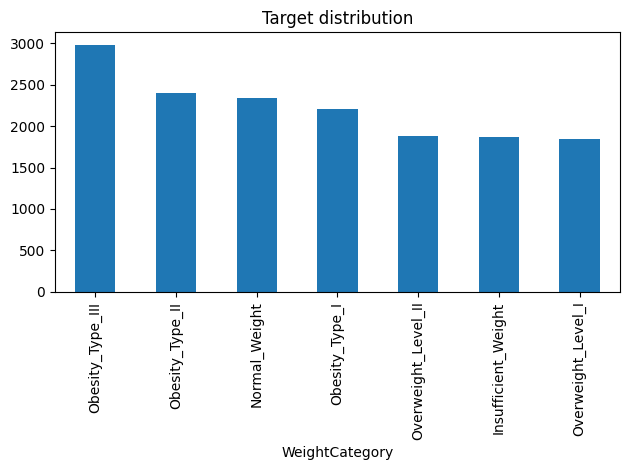

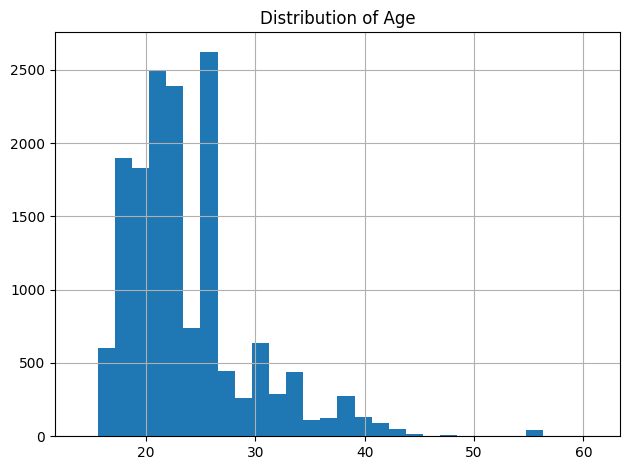

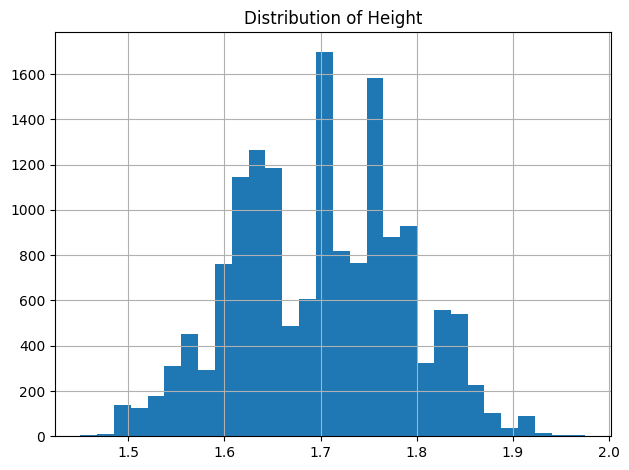

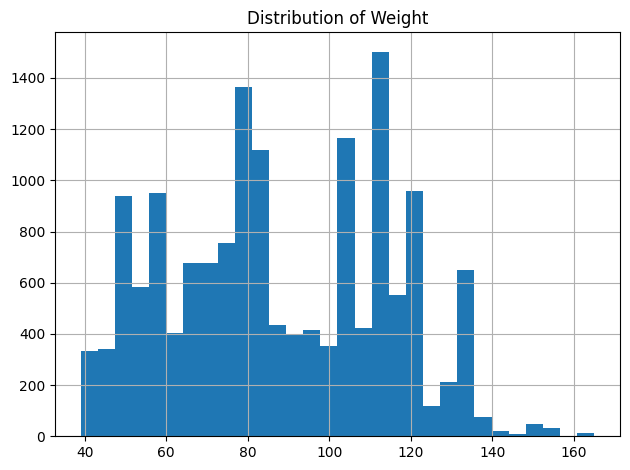

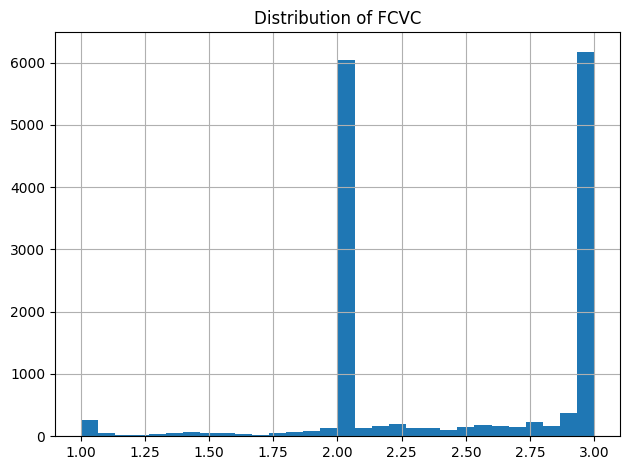

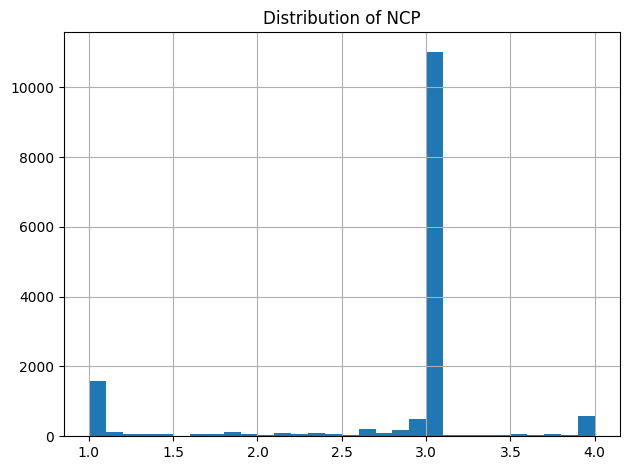

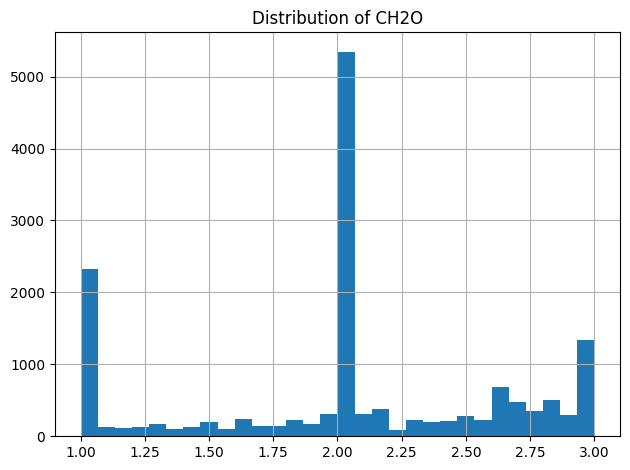

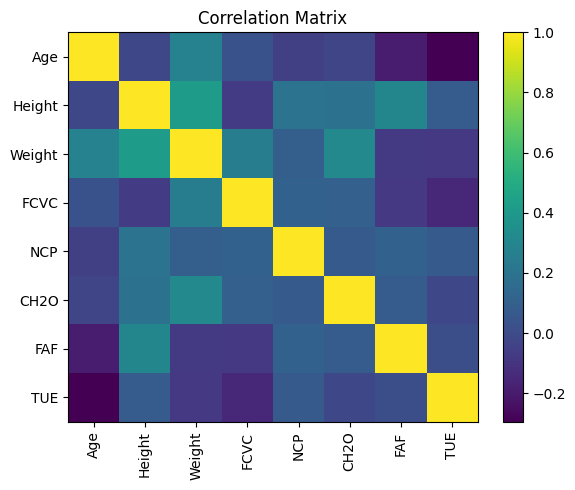

RandomForest | f1_macro (5-fold) = 0.8966 | folds = [0.8964682182462702, 0.8973191796585002, 0.8900277446531114, 0.9004954334936623, 0.8985159022402937]
XGBoost | f1_macro (5-fold) = 0.9076 | folds = [0.9057961844830026, 0.9087987128735483, 0.909583912405559, 0.9104158758229541, 0.9033526516547671]
DecisionTree | f1_macro (5-fold) = 0.8401 | folds = [0.8461269369288117, 0.829280791583419, 0.8428411213867921, 0.8379816757512604, 0.844336876964746]

comparison
          model  cv_f1_macro_mean  \
1       XGBoost          0.907589   
0  RandomForest          0.896565   
2  DecisionTree          0.840113   

                                         fold_scores  
1  [0.9057961844830026, 0.9087987128735483, 0.909...  
0  [0.8964682182462702, 0.8973191796585002, 0.890...  
2  [0.8461269369288117, 0.829280791583419, 0.8428...  
>>> using XGBoost for final training.

Final XGBoost validation F1-macro: 0.9172


In [1]:
import os
import gc
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier  


RANDOM_STATE = 50
np.random.seed(RANDOM_STATE)


# Paths
trpath = "/kaggle/input/datasetnew/train.csv"
tepath = "/kaggle/input/datasetnew/test.csv"
sub = "/kaggle/input/datasetnew/sample_submission.csv"
obes = "/kaggle/input/datasetnew/ObesityDataSet.csv"
final = "final_submission.csv"

# Load
train = pd.read_csv(trpath)
test = pd.read_csv(tepath)
sample = pd.read_csv(sub)
obesity = pd.read_csv(obes)

target_col = train.columns[-1]
id_col = "id" if "id" in train.columns else None #as no need to use id for train :( identifying basically

# EDA for train dataset only
print("EDA")
print("Shape:", train.shape)
print("\nTrain column ka info")
print(train.info())

numericcol = train.select_dtypes(include=[np.number]).columns
print("\nDescribing numeric data in train:")
print(train[numericcol].describe().T)

print("\nMissing values by column:")
print(train.isnull().sum().sort_values(ascending=False)) #basically finding null values then sum how many trues and sorting 

trainfeatures = train.drop(columns=[target_col] + ([id_col] if id_col else []))
numcols = trainfeatures.select_dtypes(include=[np.number]).columns.tolist()
catcols = trainfeatures.select_dtypes(exclude=[np.number]).columns.tolist()
print("\nNumerical columns:", numcols)
print("Categorical columns:", catcols)

print("\nTarget distribution:")
print(train[target_col].value_counts())

try:
    train[target_col].value_counts().plot(kind="bar", title="Target distribution"); plt.tight_layout(); plt.show()
    for c in numcols[:6]:
        train[c].hist(bins=30)
        plt.title(f"Distribution of {c}"); plt.tight_layout(); plt.show()
    if len(numcols) >= 2:
        corr = train[numcols].corr()
        plt.figure(figsize=(6,5))
        plt.imshow(corr, cmap="viridis", aspect='auto')
        plt.colorbar()
        plt.xticks(range(len(numcols)), numcols, rotation=90)
        plt.yticks(range(len(numcols)), numcols)
        plt.title("Correlation Matrix")
        plt.tight_layout(); plt.show()
except Exception as e:
    print("Plotting skipped: as ur kaggle doesnt support graphs :(", str(e))

# making obesity dataset good :)
obesityoutcol = obesity.columns[-1]
if obesityoutcol != target_col:
    obesity = obesity.rename(columns={obesityoutcol: target_col})#basically renaming
if "id" in obesity.columns:
    obesity = obesity.drop(columns=["id"]) #droping id col

# combining train and obesity
trainformodel = train.drop(columns=[id_col] if id_col else []) #dropping again 
combined = pd.concat([trainformodel, obesity], axis=0, ignore_index=True)

Xcombined = combined.drop(columns=[target_col])
ycombined = combined[target_col].copy()

# Test setup
test_id = test[id_col] if id_col and "id" in test.columns else pd.Series(range(len(test)), name="id")#if avaialble ok otherwise create/gen new one
Xtestraw = test.drop(columns=[id_col] if id_col else [])

# Preprocessing
numcombined = Xcombined.select_dtypes(include=[np.number]).columns.tolist()
catcombined = Xcombined.select_dtypes(exclude=[np.number]).columns.tolist()

numtransformer = Pipeline([("imputer", SimpleImputer(strategy="median"))]) #basically what i am doing is flling null values with median could use mean but mean can change/vary with outliers (1 2 3 400)
categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),  #for catergorical using most frequent one
    ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)) #ecoder changin categorical to num if nanto -1
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numtransformer, numcombined),
        ("cat", categorical_transformer, catcombined),
    ],
    remainder="drop"
)

# Encode target
y_le = LabelEncoder()  #basically ouput is categorical so changing to num as xg lgm rf cant work with them
y_encoded = y_le.fit_transform(ycombined)

# Crossvalidation basically 5fold  
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE) #splitting data into 5 fold basically 80% train (4fold) 20%test (1fold)
scoring = "f1_macro"

def cvscore(pipe, X, y, cv, scoring):
    scores = cross_val_score(pipe, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    return float(scores.mean()), [float(s) for s in scores]

# Best tuned parameters
best_params_xgb = {
    'booster': 'gbtree',
    'objective': 'multi:softmax',
    'verbosity': 0,
    'tree_method': "gpu_hist" if os.environ.get("CUDA_VISIBLE_DEVICES", "") not in ["", "-1", None] else "hist",
    'grow_policy': 'depthwise',
    'max_depth': 23,
    'learning_rate': 0.050053726931263504,
    'n_estimators': 982,
    'gamma': 0.5354391952653927,
    'min_child_weight': 2.561508074944465e-07,
    'subsample': 0.7060590452456204,
    'colsample_bytree': 0.37939433412123275,
    'reg_alpha': 9.150224029846654e-08,
    'reg_lambda': 5.671063656994295e-08,
    'eval_metric': 'mlogloss',
    'random_state': RANDOM_STATE
}

best_params_dt = {
    "criterion": "gini",
    "max_depth": None,
    "random_state": RANDOM_STATE
}

# Models
rfcls = RandomForestClassifier(
    n_estimators=400, max_depth=None, min_samples_split=2,
    random_state=RANDOM_STATE, n_jobs=-1
)
xgcls = XGBClassifier(**best_params_xgb)
dtcls = DecisionTreeClassifier(**best_params_dt)  # <<< Decision Tree in place of LightGBM

models = {
    "RandomForest": rfcls,
    "XGBoost": xgcls,
    "DecisionTree": dtcls  # <<< updated key
}

# Model comparison
results = []
bestname, bestpipe, bestmean = None, None, -np.inf

for name, clf in models.items():
    pipe = Pipeline([("prep", preprocess), ("clf", clf)])
    meancv, foldscores = cvscore(pipe, Xcombined, y_encoded, cv, scoring)
    results.append({"model": name, "cv_f1_macro_mean": meancv, "fold_scores": foldscores})
    print(f"{name} | {scoring} (5-fold) = {meancv:.4f} | folds = {foldscores}")
    if meancv > bestmean:
        bestmean, bestname, bestpipe = meancv, name, pipe

print("\ncomparison")
print(pd.DataFrame(results).sort_values("cv_f1_macro_mean", ascending=False))
print(f">>> using {bestname} for final training.")

# Final training
Xtr, Xval, ytr, yval = train_test_split(
    Xcombined, y_encoded, test_size=0.15,
    stratify=y_encoded, random_state=RANDOM_STATE
)

prepfitted = preprocess.fit(Xtr)
Xtrp = prepfitted.transform(Xtr)
Xvalp = prepfitted.transform(Xval)
Xtestp = prepfitted.transform(Xtestraw)

if bestname == "RandomForest":
    final_model = rfcls.fit(Xtrp, ytr)
elif bestname == "XGBoost":
    final_model = xgcls.fit(
        Xtrp, ytr,
        eval_set=[(Xvalp, yval)],
        early_stopping_rounds=100,
        verbose=False
    )
elif bestname == "DecisionTree":  # <<< updated condition
    final_model = dtcls.fit(Xtrp, ytr)  # <<< simple fit (no eval_set for DT)

# Validation
valpred = final_model.predict(Xvalp)
valf1 = f1_score(yval, valpred, average="macro")
print(f"\nFinal {bestname} validation F1-macro: {valf1:.4f}")

# Predict test
testpredenc = final_model.predict(Xtestp)
testpred = y_le.inverse_transform(testpredenc)

# Submission
targetsubcol = sample.columns[-1]
submission = pd.DataFrame({"id": test_id, targetsubcol: testpred})
assert submission.isnull().sum().sum() == 0
submission.to_csv(final, index=False)
